<a href="https://colab.research.google.com/github/MarioCastilloM/AlgoTrading/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
dense (Dense)                (None, 1, 1)              101       
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
3/3 [==============================] - 22s 746ms/step - loss: 0.2492 - val_loss: 0.1950
Epoch 2/60
3/3 [======

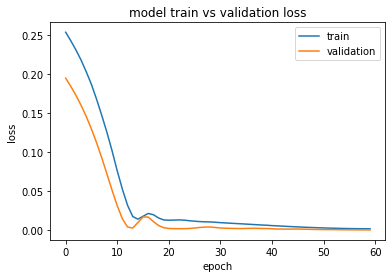

'temp-plot.html'

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 18 15:19:42 2021

@author: marioc
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import pandas_datareader as web
import plotly.express as px
from keras import Model, optimizers
# import plotly.graph_objs as go
import datetime as dt
from plotly.offline import plot

#%% función gráfico
def visualizar(df, title):
    plt.figure(figsize=(20,20))
    fig = px.line(data=df, x = df['Date'])
    for i in df.columns:
        fig.add_scartter(x = df['Date'], y = df[i], name = i)
    fig.show()
#%% importación de datos

""" Lectura de los datos, relacionando los valores con su fecha. 
DAAA Moodys bond AAA
T10Y3M tbill 3months
DGS10 10 year treasury bond
DTB3 3 month tbill 2nd market
DGS5 5 year treasury
T10YIE 10 year breakeven inflation rate
T5YIE 5 year
T5YIFR 5year forward inflation expectation rate
MICH inflation expectation
CPALTT01USM657N IPC


"""

tickers = ['FEDFUNDS']

start = dt.date(1982, 1, 1)
end = dt.date(1994, 12, 31)

df = pd.DataFrame()
for ticker in tickers:
    x = web.fred.FredReader(ticker, start, end).read()
    x['Ticker'] = ticker
    df = df.append(x)

df['Date'] = df.index
df = df[df.FEDFUNDS.notnull()]

# df = df[df['Ticker']=='CAP.SN']
df['Target'] = df['FEDFUNDS'].shift(-1)
#%% tratamiento de los datos
""" Solo vamos a basarnos en el Precio más alto de la acción (columna 'High') """

largo=int(len(df)*0.7)

priceSet = pd.DataFrame(df[['Date', 'FEDFUNDS', 'Target']])


""" Normalización del set de entrenamiento (valores entre 0 y 1). """
sc = MinMaxScaler(feature_range=(0,1))
priceSetScaled = sc.fit_transform(priceSet.drop(columns=['Date']))

X = priceSetScaled[:,:1]
X_train = X[:largo]
X_test = X[largo:]


y = priceSetScaled[:,1:]
y_train = y[:largo]
y_test = y[largo:]

# """ Vamos a entrenar a la Red proporcionando 100 datos de entrada y 1 de salida en cada iteración """
# timeSteps = 100
# xTrain = []
# yTrain = []

# """ xTrain = lista de conjuntos de 100 datos.
#     yTrain = lista de valores """
# for i in range(0, len(trainingSetScaled)-timeSteps):
#     xTrain.append(trainingSetScaled[i:i+timeSteps, 0])
#     yTrain.append(trainingSetScaled[i+timeSteps,0])

""" Preferiblemente usar numpy ya que:
    1. Deberemos transformar xTrain (actualmente de dos dimensiones) a tres dimensiones.
    2. Los programas que usan Numpy generalmente son más rápidos (sobretodo en IA).
"""
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

#%% Especificacion del modelo
""" Parámetros que deberemos proporcionar a Keras (Sequential()). """
dim_entrada = (X_train.shape[1], X_train.shape[2]) # No hace falta la primera.
dim_salida = 1
na = 100

""" units = neuronas de la capa | return_sequences = hay más capas? | input_shape = dimensión entrada | 
    Dropout(%) = Número de neuronas que queremos ignorar en la capa de regularización (normalmente es de un 20%). """
regresor = Sequential() # Inicializa el modelo


""" capa 1, 3 y 3 """
inputs = Input(shape=(dim_entrada))
x = LSTM(units=na, return_sequences = True)(inputs)
x = LSTM(units=na, return_sequences = True)(x)
x = LSTM(units=na, return_sequences = True)(x)

""" capa output """
output = Dense(units=dim_salida, activation='linear')(x)

model = Model(inputs, output)

adam = optimizers.Adam(lr=0.0007, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam, loss='mse') # mse = mean_squared_error

model.summary()
#%% ajuste del modelo
""" Encajar Red Neuronal en Set Entrenamiento """
""" epochs = iteraciones para entrenar tu modelo | 
batch_size = numero ejemplos entrenamiento (cuanto más alto, más memoria necesitarás).  """
history = model.fit(X_train,y_train, epochs=60, batch_size=32, validation_split=0.2)

history.history.keys()
#%% overfitting

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#%% predicción
""" Normalizar el conjunto de Test y relizamos las mismas operaciones que anteriormente """
# auxTest = sc.fit_transform(X_test)
# xTest = []
# yTest = []

# for i in range(0, len(auxTest)-timeSteps):
#     xTest.append(auxTest[i:i+timeSteps,0])
#     yTest.append(auxTest[i+timeSteps, 0])
    
# xTest = np.array(xTest)
# xTest = np.reshape(xTest, (xTest.shape[0],xTest.shape[1], 1))

""" Realizamos la Predicción """
prediccion = model.predict(X_test)

""" Dejamos sólo la primera dimension de la predicción """
# test_predicted = []
# for i in prediccion:
#   test_predicted.append(i[0])

#%% data frame
df1 = pd.DataFrame(priceSetScaled)
df1.columns = ['FEDFUNDS', 'Target']
df1['Fecha'] = df.index
df1.drop(columns = ['FEDFUNDS'])
df1
#%%
predicted_df = pd.DataFrame(prediccion[:,0])
predicted_df['Fecha'] = df1.Fecha[largo:].reset_index().iloc[:,1]
predicted_df.columns = ['Normalized Predicted Price', 'Fecha']
predicted_df
#%% grafico
""" grafico """
fig = px.line(data_frame=df1, x = 'Fecha', y = 'FEDFUNDS', title='FEDFUNDS actual vs LSTM Predicted')
fig.add_scatter(x = predicted_df['Fecha'], y = predicted_df.iloc[:,0], name = 'Predicho')
plot(fig)

#%% transformación inversa
# """ Desnormalizamos la Predicción para que se encuentre entre valores normales. """
# prediccion = sc.inverse_transform(prediccion[:,0])
#%% visualizacion de los precios
# Graficar resultados








